In [89]:
#Import

import os
import cv2

from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from skimage import color
from skimage.feature import hog

from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

import joblib


In [90]:
# Fungsi Load Images

def load_images_and_labels(dataset_path, image_size=(128, 128)):
    images = []
    labels = []

    for label_folder in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label_folder)

        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            image = cv2.imread(file_path)
            image = cv2.resize(image, image_size)
            images.append(image)
            labels.append(label_folder)

    return images, labels



In [91]:
# Fungsi Ekstraksi fitur HOG

def extract_hog_features(images):
    features = []

    for image in images:
        gray = color.rgb2gray(image)
        hog_feature, _ = hog(
            gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys',
            visualize=True
        )
        features.append(hog_feature)

    return np.array(features)

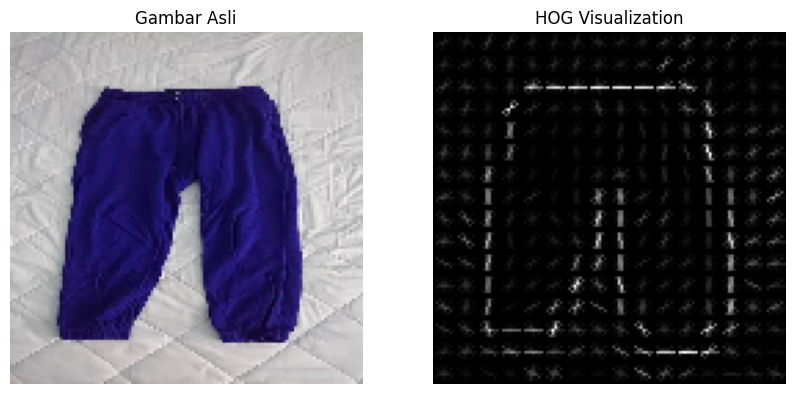

In [ ]:
# Visualisasi ekstraksi Fitur HOG
def contoh_visual_hog(image):
    gray = color.rgb2gray(image)
    hog_feature, hog_image = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True
    )
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(image)
    ax[0].set_title('Gambar Asli')
    ax[0].axis('off')
    ax[1].imshow(hog_image, cmap='gray')
    ax[1].set_title('HOG Visualization')
    ax[1].axis('off')
    plt.show()

# Contoh visualisasi untuk satu gambar train
contoh_visual_hog(images[0])

In [93]:
# Fungsi Extraksi Fitur Color Histogram

def extract_color_histogram_features(images, bins=256):
    features = []

    for image in images:
        chans = cv2.split(image) 
        hist_features = []

        for chan in chans:
            hist = cv2.calcHist([chan], [0], None, [bins], [0, 256])
            hist = cv2.normalize(hist, hist).flatten()
            hist_features.extend(hist)

        features.append(hist_features)

    return np.array(features)


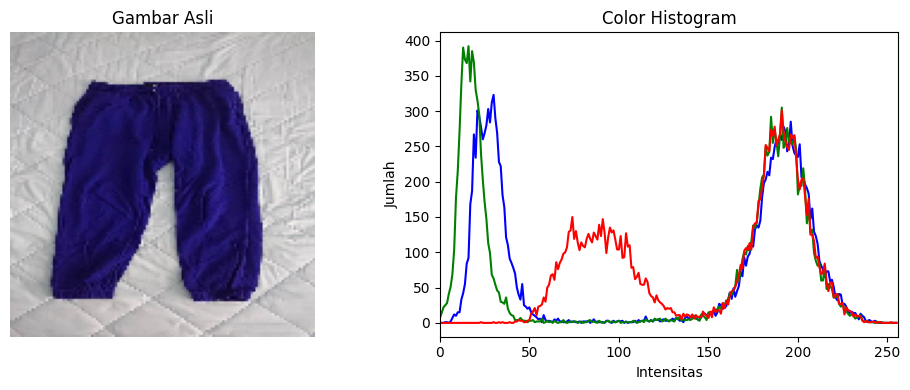

In [ ]:
# Visualisasi ekstraksi Fitur Color Histogram
def contoh_visual_color_histogram(image):
    chans = cv2.split(image)
    colors = ('b', 'g', 'r')
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title('Gambar Asli')
    plt.axis('off')
    plt.subplot(1,2,2)
    for chan, color in zip(chans, colors):
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        plt.plot(hist, color=color)
    plt.title('Color Histogram')
    plt.xlabel('Intensitas')
    plt.ylabel('Jumlah')
    plt.xlim([0,256])
    plt.tight_layout()
    plt.show()

contoh_visual_color_histogram(images[0])

In [95]:
# Fungsi Ekstraksi fitur Tekstur(LBP)

def extract_lbp_features(images):
    features = []

    for image in images:
        gray = color.rgb2gray(image)
        gray_uint8 = (gray * 255).astype("uint8")
        lbp = local_binary_pattern(gray_uint8, P=8, R=1, method='uniform')

        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6) 

        features.append(hist)

    return np.array(features)


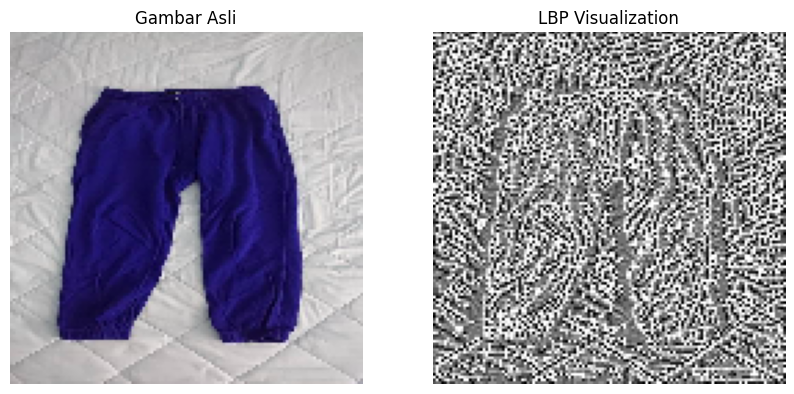

In [ ]:
# Visualisasi ekstraksi Fitur LBP
def contoh_visual_lbp(image):
    gray = color.rgb2gray(image)
    gray_uint8 = (gray * 255).astype("uint8")
    lbp = local_binary_pattern(gray_uint8, P=8, R=1, method='uniform')
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(image)
    ax[0].set_title('Gambar Asli')
    ax[0].axis('off')
    ax[1].imshow(lbp, cmap='gray')
    ax[1].set_title('LBP Visualization')
    ax[1].axis('off')
    plt.show()

contoh_visual_lbp(images[0])

In [97]:
# Load Train Images

images, labels = load_images_and_labels("gambar/train")

label_counts = Counter(labels)
print("Jumlah gambar per label:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

Jumlah gambar per label:
Celana_Panjang: 50
Gaun: 50
Jaket: 50


In [98]:
# Ekstraksi Fitur Gambar Train

hog_features = extract_hog_features(images)
color_histogram_features = extract_color_histogram_features(images)
lbp_features = extract_lbp_features(images)

In [99]:
#Encode Label Train
le = LabelEncoder()
y = le.fit_transform(labels)

### HOG + Color

In [100]:
# Gabungkan Fitur

X1 = np.concatenate([hog_features, color_histogram_features], axis=1)

# Split data train/test
X1_train, X1_test, y_train, y_test = train_test_split(
    X1, y, test_size=0.2, random_state=42)

In [101]:
# Train Model

clf1 = SVC(kernel='linear')
clf1.fit(X1_train, y_train)

y_pred1 = clf1.predict(X1_test)
print("Accuracy:", accuracy_score(y_test, y_pred1))
print("Classification Report:\n", classification_report(y_test, y_pred1, target_names=le.classes_))


Accuracy: 0.8333333333333334
Classification Report:
                 precision    recall  f1-score   support

Celana_Panjang       0.83      1.00      0.91        10
          Gaun       0.73      0.89      0.80         9
         Jaket       1.00      0.64      0.78        11

      accuracy                           0.83        30
     macro avg       0.85      0.84      0.83        30
  weighted avg       0.86      0.83      0.83        30



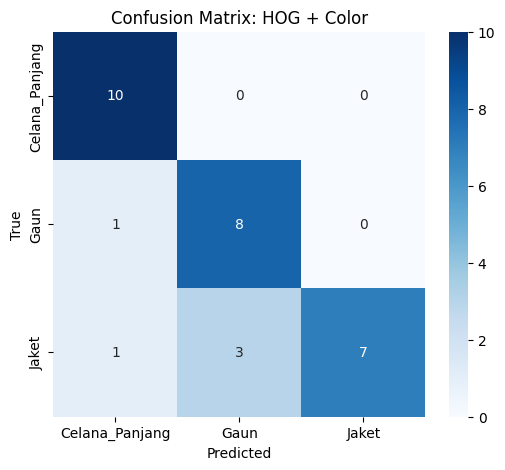

In [102]:
# Heatmap Confusion Matrix HOG + Color
cm1 = confusion_matrix(y_test, y_pred1)
plt.figure(figsize=(6,5))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix: HOG + Color')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Color + LBP

In [103]:
# Gabungkan Fitur

X2 = np.concatenate([color_histogram_features, lbp_features], axis=1)

# Split data train/test
X2_train, X2_test, y_train, y_test = train_test_split(
    X2, y, test_size=0.2, random_state=42)

In [104]:
# Train Model

clf2 = SVC(kernel='linear')
clf2.fit(X2_train, y_train)

y_pred2 = clf2.predict(X2_test)
print("Accuracy:", accuracy_score(y_test, y_pred2))
print("Classification Report:\n", classification_report(y_test, y_pred2, target_names=le.classes_))


Accuracy: 0.5
Classification Report:
                 precision    recall  f1-score   support

Celana_Panjang       0.36      0.50      0.42        10
          Gaun       0.75      0.67      0.71         9
         Jaket       0.50      0.36      0.42        11

      accuracy                           0.50        30
     macro avg       0.54      0.51      0.51        30
  weighted avg       0.53      0.50      0.51        30



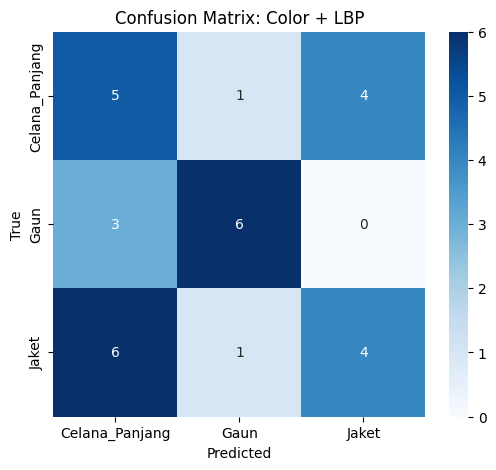

In [105]:
# Heatmap Confusion Matrix Color + LBP
cm2 = confusion_matrix(y_test, y_pred2)
plt.figure(figsize=(6,5))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix: Color + LBP')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### LBP + HOG

In [106]:
# Gabungkan Fitur

X3 = np.concatenate([hog_features, lbp_features], axis=1)

# Split data train/test
X3_train, X3_test, y_train, y_test = train_test_split(
    X3, y, test_size=0.2, random_state=42)

In [107]:
# Train Model

clf3 = SVC(kernel='linear')
clf3.fit(X3_train, y_train)

y_pred3 = clf3.predict(X3_test)
print("Accuracy:", accuracy_score(y_test, y_pred3))
print("Classification Report:\n", classification_report(y_test, y_pred3, target_names=le.classes_))


Accuracy: 0.8
Classification Report:
                 precision    recall  f1-score   support

Celana_Panjang       0.83      1.00      0.91        10
          Gaun       0.70      0.78      0.74         9
         Jaket       0.88      0.64      0.74        11

      accuracy                           0.80        30
     macro avg       0.80      0.80      0.79        30
  weighted avg       0.81      0.80      0.79        30



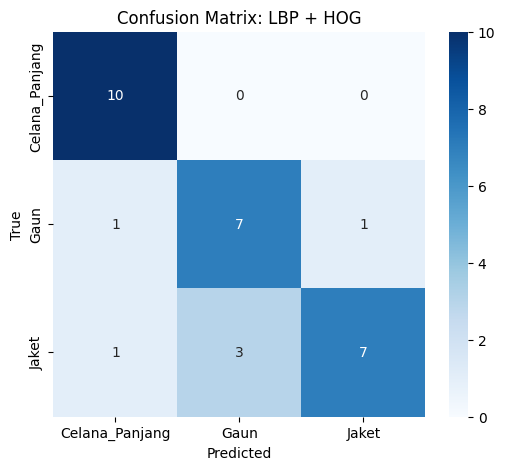

In [108]:
# Heatmap Confusion Matrix LBP + HOG
cm3 = confusion_matrix(y_test, y_pred3)
plt.figure(figsize=(6,5))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix: LBP + HOG')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### HOG + LBP + Color

In [109]:
# Gabungkan Fitur
X = np.concatenate([hog_features, color_histogram_features, lbp_features], axis=1)

# Split data train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [110]:
# Train Model

clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.8333333333333334
Classification Report:
                 precision    recall  f1-score   support

Celana_Panjang       0.83      1.00      0.91        10
          Gaun       0.73      0.89      0.80         9
         Jaket       1.00      0.64      0.78        11

      accuracy                           0.83        30
     macro avg       0.85      0.84      0.83        30
  weighted avg       0.86      0.83      0.83        30



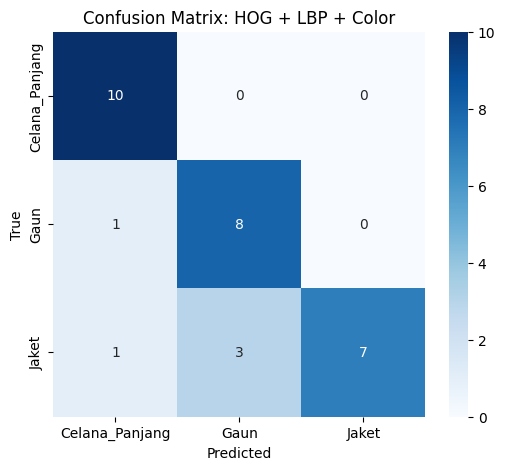

In [111]:
# Heatmap Confusion Matrix HOG + LBP + Color
cm4 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm4, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix: HOG + LBP + Color')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

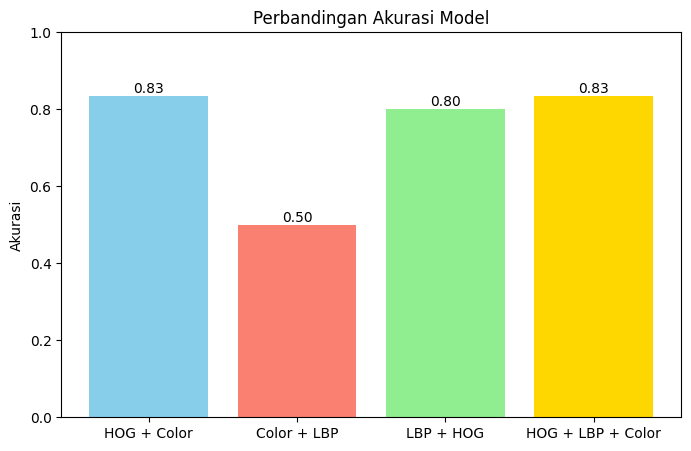

In [ ]:
# Grafik Perbandingan Akurasi Semua Model

akurasi_models = [
    accuracy_score(y_test, y_pred1),
    accuracy_score(y_test, y_pred2),
    accuracy_score(y_test, y_pred3),
    accuracy_score(y_test, y_pred)
]
nama_models = [
    'HOG + Color',
    'Color + LBP',
    'LBP + HOG',
    'HOG + LBP + Color'
]

plt.figure(figsize=(8,5))
bars = plt.bar(nama_models, akurasi_models, color=['skyblue','salmon','lightgreen','gold'])
plt.ylim(0,1)
plt.ylabel('Akurasi')
plt.title('Perbandingan Akurasi Model')
for bar, acc in zip(bars, akurasi_models):
    plt.text(bar.get_x() + bar.get_width()/2, acc, f'{acc:.2f}', ha='center', va='bottom')
plt.show()

### Save dan Load Model

In [113]:
# Dump Model

# joblib.dump(clf, 'model_svm.pkl')
# joblib.dump(le, 'label_encoder.pkl')
# print("Model dan LabelEncoder berhasil disimpan.")


In [114]:
# Load Model

# clf = joblib.load('model_svm.pkl')
# le = joblib.load('label_encoder.pkl')
# print("Model dan LabelEncoder berhasil di load.")

### Test

In [115]:
# Load Test Images

test_images, test_labels = load_images_and_labels("gambar/test")

test_label_counts = Counter(test_labels)
print("Jumlah gambar per label:")
for label, count in test_label_counts.items():
    print(f"{label}: {count}")

Jumlah gambar per label:
Celana_Panjang: 20
Gaun: 20
Jaket: 20


In [116]:
# Ekstraksi Fitur Gambar Test

test_hog_features = extract_hog_features(test_images)
test_color_features = extract_color_histogram_features(test_images)
test_lbp_features = extract_lbp_features(test_images)

In [117]:
# Gabungkan Fitur data Test Sesuai Model yang dipakai
X_test_all = np.concatenate([test_hog_features, test_color_features, test_lbp_features], axis=1)

# Encode label test
y_test_all = le.transform(test_labels)

# Prediksi semua gambar test
y_pred_all = clf.predict(X_test_all)

In [118]:
# Evaluasi hasil prediksi
correct_per_class = defaultdict(int)
total_per_class = defaultdict(int)

for true, pred, label in zip(y_test_all, y_pred_all, test_labels):
    total_per_class[label] += 1
    if true == pred:
        correct_per_class[label] += 1


print("Akurasi pada data test:", accuracy_score(y_test_all, y_pred_all))
print("Jumlah prediksi benar per kelas:")
for label in le.classes_:
    print(f"{label}: {correct_per_class[label]} dari {total_per_class[label]}")

Akurasi pada data test: 0.6666666666666666
Jumlah prediksi benar per kelas:
Celana_Panjang: 14 dari 20
Gaun: 10 dari 20
Jaket: 16 dari 20
